# Real-World Data Processing with RNN, LSTM, and GRU in PyTorch

This notebook demonstrates how to use RNN, LSTM, and GRU on real-world time-series data and visualize the training performance.

In [3]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import os
import kagglehub
from tqdm import tqdm

/home/riley/networking_llm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
        print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [5]:
# Path to the cached dataset
cache_path = os.path.expanduser("~/.cache/kagglehub/datasets")

data_path = os.path.join(cache_path, "mryanm/luflow-network-intrusion-detection-data-set/versions/240")

if not os.path.exists(data_path):
    # Download latest version
    data_path = kagglehub.dataset_download("mryanm/luflow-network-intrusion-detection-data-set")
    
# List to store dataframes
df_list = []

# Load and optimize each CSV
for year in tqdm(sorted(os.listdir(data_path))):  # Sorting for consistency
    year_path = os.path.join(data_path, year)
    if os.path.isdir(year_path):
        for month in sorted(os.listdir(year_path)):
            month_path = os.path.join(year_path, month)
            if os.path.isdir(month_path):
                for day in sorted(os.listdir(month_path)):
                    day_path = os.path.join(month_path, day)
                    if os.path.isdir(day_path):
                        for file in os.listdir(day_path):
                            if file.endswith(".csv"):
                                full_path = os.path.join(day_path, file)
                                data = pd.read_csv(full_path)

                                # Extract date info safely
                                y, m, d = map(int, file.split(".")[:3])
                                data["Year"] = y
                                data["Month"] = m
                                data["Day"] = d

                                # Reduce memory usage BEFORE adding to list
                                data = reduce_mem_usage(data, verbose=False)
                                df_list.append(data)

# Final concatenation
df = pd.concat(df_list, ignore_index=True)

100%|██████████| 4/4 [03:05<00:00, 46.37s/it] 


KeyboardInterrupt: 

In [ ]:
df.info()

In [ ]:
# Load a real-world dataset (Stock Prices Example)
# The original URL was returning a 404 error (Not Found)
# Updated to a working URL for the AAPL stock data
url = "https://raw.githubusercontent.com/plotly/datasets/master/finance-charts-apple.csv"
df = pd.read_csv(url, parse_dates=['Date'], index_col='Date')

# Rename the 'AAPL.Close' column to 'close' to match the original code
df = df.rename(columns={'AAPL.Close': 'close'})

# Select 'close' price for modeling
data = df[['close']].values

# Normalize the data
scaler = MinMaxScaler(feature_range=(-1, 1))
data = scaler.fit_transform(data)

# Function to create sequences for RNNs
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        labels.append(data[i+seq_length])
    return torch.tensor(sequences, dtype=torch.float32), torch.tensor(labels, dtype=torch.float32)

seq_length = 30  # Use past 30 days to predict the next day
X, y = create_sequences(data, seq_length)

# Reshape X to match PyTorch format (batch_size, sequence_length, features)
X = X.view(X.shape[0], seq_length, 1)

<ipython-input-2-7f6c0953f7d5>:31: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(sequences, dtype=torch.float32), torch.tensor(labels, dtype=torch.float32)


## Define RNN, LSTM, and GRU Models

In [3]:

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Take the last time step's output
        return out

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Take the last time step's output
        return out

class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])  # Take the last time step's output
        return out


## Training the Models and Recording Loss

In [4]:

def train_model(model, X, y, epochs=100, learning_rate=0.001):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses = []

    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(X)
        loss = criterion(output, y.view(-1, 1))
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

    return losses

# Initialize models
rnn_model = RNNModel(input_size=1, hidden_size=64, output_size=1)
lstm_model = LSTMModel(input_size=1, hidden_size=64, output_size=1)
gru_model = GRUModel(input_size=1, hidden_size=64, output_size=1)

# Train models and record loss
rnn_losses = train_model(rnn_model, X, y)
lstm_losses = train_model(lstm_model, X, y)
gru_losses = train_model(gru_model, X, y)


Epoch 0, Loss: 0.2874
Epoch 10, Loss: 0.1157
Epoch 20, Loss: 0.0209
Epoch 30, Loss: 0.0175
Epoch 40, Loss: 0.0141
Epoch 50, Loss: 0.0133
Epoch 60, Loss: 0.0128
Epoch 70, Loss: 0.0125
Epoch 80, Loss: 0.0122
Epoch 90, Loss: 0.0120
Epoch 0, Loss: 0.2558
Epoch 10, Loss: 0.1956
Epoch 20, Loss: 0.1286
Epoch 30, Loss: 0.0406
Epoch 40, Loss: 0.0310
Epoch 50, Loss: 0.0228
Epoch 60, Loss: 0.0197
Epoch 70, Loss: 0.0172
Epoch 80, Loss: 0.0156
Epoch 90, Loss: 0.0144
Epoch 0, Loss: 0.2122
Epoch 10, Loss: 0.1469
Epoch 20, Loss: 0.0651
Epoch 30, Loss: 0.0315
Epoch 40, Loss: 0.0174
Epoch 50, Loss: 0.0134
Epoch 60, Loss: 0.0128
Epoch 70, Loss: 0.0119
Epoch 80, Loss: 0.0112
Epoch 90, Loss: 0.0106


## Visualizing the Training Loss

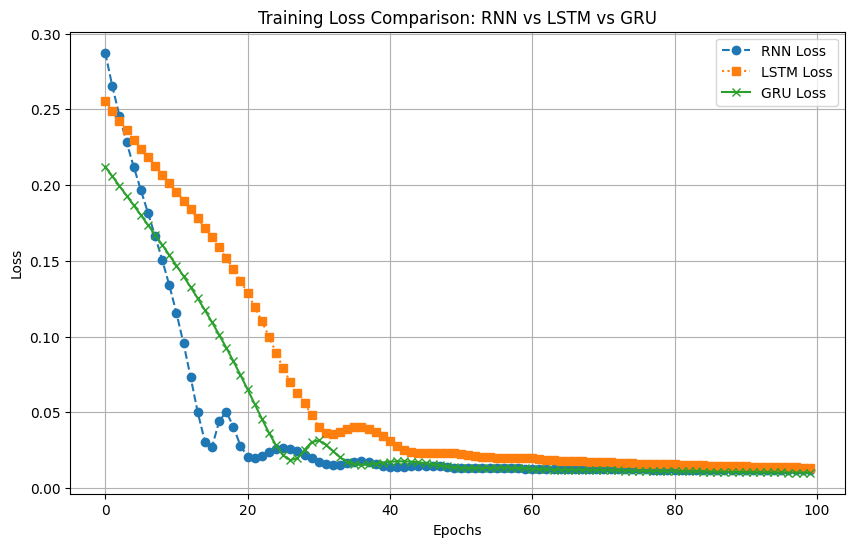

In [5]:

# Plot Training Loss Curves
plt.figure(figsize=(10,6))
plt.plot(rnn_losses, label='RNN Loss', linestyle='dashed', marker='o')
plt.plot(lstm_losses, label='LSTM Loss', linestyle='dotted', marker='s')
plt.plot(gru_losses, label='GRU Loss', linestyle='solid', marker='x')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Comparison: RNN vs LSTM vs GRU')
plt.legend()
plt.grid(True)
plt.show()


## Testing the Models on New Data

In [6]:

def predict(model, input_seq):
    model.eval()
    input_seq = torch.tensor(input_seq, dtype=torch.float32).view(1, seq_length, 1)
    with torch.no_grad():
        prediction = model(input_seq)
    return scaler.inverse_transform(prediction.numpy().reshape(-1, 1))[0][0]

# Example Test Case (Predict Next Day's Closing Price)
test_seq = data[-seq_length:].reshape(-1, 1)  # Use the last 30 days
print("RNN Prediction:", predict(rnn_model, test_seq))
print("LSTM Prediction:", predict(lstm_model, test_seq))
print("GRU Prediction:", predict(gru_model, test_seq))


RNN Prediction: 133.19913
LSTM Prediction: 132.99136
GRU Prediction: 134.18974


## Summary and Insights

- The loss curves indicate how well each model trains over time.
- **LSTM and GRU** generally perform better than RNN on time-series data.
- **LSTM retains long-term memory well,** making it good for stock price prediction.
- **GRU is faster than LSTM** and performs similarly.
- **RNN struggles** with long-term dependencies due to vanishing gradients.
- The predictions indicate how each model forecasts stock prices based on historical data.